In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
snehilsanyal_construction_site_safety_image_dataset_roboflow_path = kagglehub.dataset_download('snehilsanyal/construction-site-safety-image-dataset-roboflow')

print('Data source import complete.')


Using Colab cache for faster access to the 'construction-site-safety-image-dataset-roboflow' dataset.
Data source import complete.


# About

- In this notebook I will train Yolo v9 model to detect PPE (Personal Protective Equipment), using [this existing dataset](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow) from [Roboflow](https://universe.roboflow.com/)
- In the [next notebook](https://www.kaggle.com/hinepo/yolov8-inference-for-red-zone-application) I will use this custom model to make inference on videos and post-process the results so they can be used in a Red Zone/Trespassing detection application
- This notebook is a generic training pipeline that you can use to train any Yolo model for object detection task on any dataset (images/number of classes), as long as you provide the dataset in the correct folder structure accepted by Yolo and the annotations/labels in Yolo format
- [Ultralytics - docs](https://docs.ultralytics.com/)
- [Ultralytics - github](https://github.com/ultralytics/ultralytics)

___

[CSS (Construction Site Safety) Dataset](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow):

- Labels in this dataset:
    - 0: Hardhat
    - 1: Mask
    - 2: NO-Hardhat
    - 3: NO-Mask
    - 4: NO-Safety Vest
    - 5: Person
    - 6: Safety Cone
    - 7: Safety Vest
    - 8: Machinery
    - 9: Vehicle


- More info:
    - Number of classes: 10
    - Label Annotation: YOLO format (.txt)
      - `[class_id, center_x, center_y, width, height]`
      
___      

Yolo Dataset folder structure: the paths to these folders will be written to a YAML file that will be used by Yolo.

```
Custom dataset directory (root)
    - train
        - images (folder including all training images)
        - labels (folder including all training labels)
    - validation
        - images (folder including all validation images)
        - labels (folder including all validation labels)
    - test
        - images (folder including all test images)
        - labels (folder including all test labels)

```

**<font color='orange'>If you like this notebook, don't forget to show your support with your upvote!</font>**

In [ ]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e9ebcec6-30af-bbc1-0718-990f1def4b3a)


In [ ]:
!pip install kaggle
import os
import json
from zipfile import ZipFile
from PIL import Image

kaggle_credentails = json.load(open("/content/kaggle.json"))

# setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

#!/bin/bash
!kaggle datasets download snehilsanyal/construction-site-safety-image-dataset-roboflow


# Unzip the downloaded dataset
with ZipFile("construction-site-safety-image-dataset-roboflow.zip", 'r') as zip_ref:
    zip_ref.extractall()

Dataset URL: https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow
License(s): Attribution 4.0 International (CC BY 4.0)
 63% 129M/206M [00:00<00:00, 1.34GB/s]
100% 206M/206M [00:00<00:00, 805MB/s] 


In [ ]:
%%time

! pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.2 MB/s eta 0:00:00
CPU times: user 2.29 s, sys: 302 ms, total: 2.59 s
Wall time: 8.27 s


# Installs/Imports

In [ ]:
import ultralytics
print(ultralytics.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
8.3.199


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [ ]:
! wandb disabled

W&B disabled.


# CFG

- CFG class enables easy and organized experimentation
- Set `DEBUG = True` to make quick experiments

In [ ]:
class CFG:
    DEBUG = False
    FRACTION = 0.10 if DEBUG else 1.0
    SEED = 88

    # classes
    CLASSES = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
               'NO-Safety Vest', 'Person', 'Safety Cone',
               'Safety Vest', 'machinery', 'vehicle']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 80 # 100
    BATCH_SIZE = 16

    BASE_MODEL = 'yolov8s' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.025
    PATIENCE = 25
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # paths
    CUSTOM_DATASET_DIR = '/content/css-data/'
    OUTPUT_DIR = './'

# Create YAML file

- Create ```data.yaml``` file properly formatted to be used by Yolo

In [ ]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [ ]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: /content/css-data/test
train: /content/css-data/train
val: /content/css-data/valid



# Dataset

- Check some images
- Image utils

## Visualize one image

In [ ]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



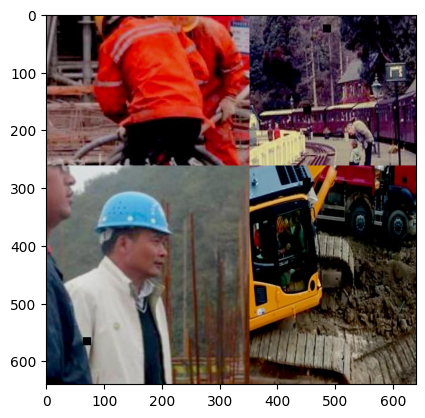

In [ ]:
example_image_path = '/content/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

## Visualize many images

In [ ]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

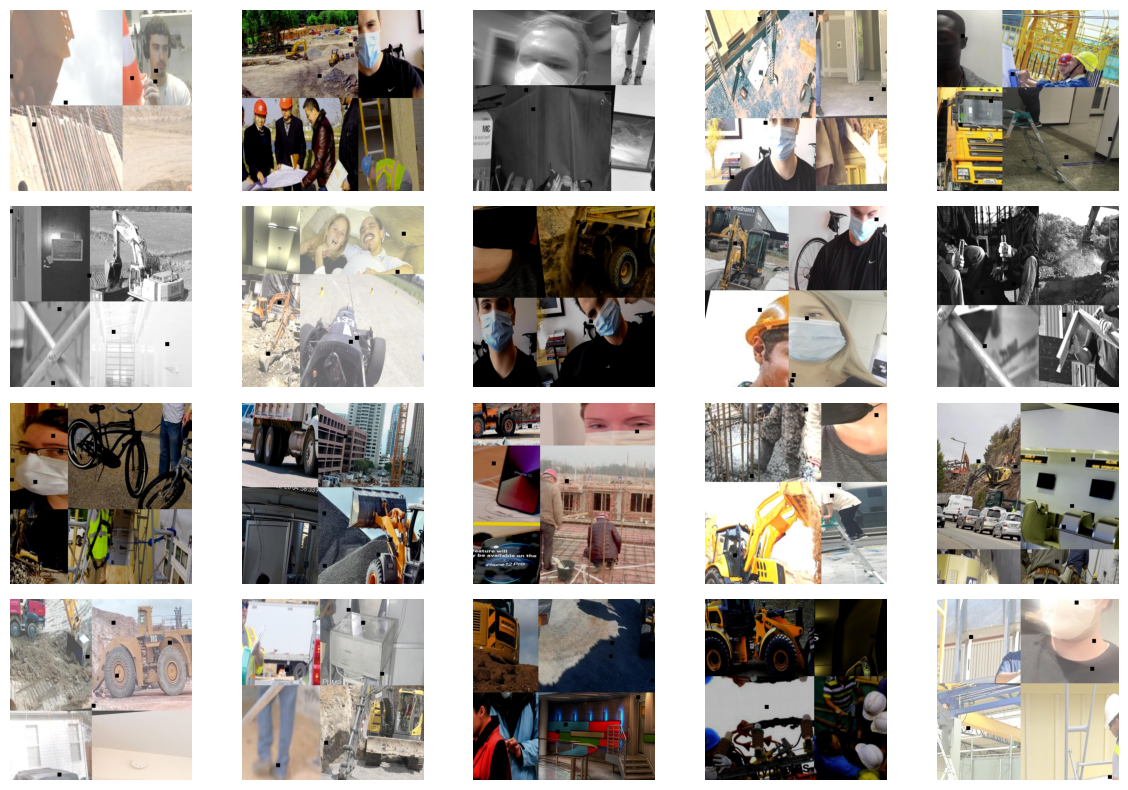

In [ ]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)
# plot_random_images_from_folder(folder_path, num_images=20, seed=54)

## Image properties

In [ ]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [ ]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

## Dataset statistics

In [ ]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 44.4 ms, sys: 34.7 ms, total: 79.1 ms
Wall time: 80.5 ms


,Mode,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,machinery,vehicle,Data_Volume
0,train,1314,1096,1380,1531,1864,2526,631,1319,2101,744,2605
1,valid,42,19,37,44,56,84,13,28,26,16,114
2,test,30,16,25,30,36,59,8,22,22,15,82


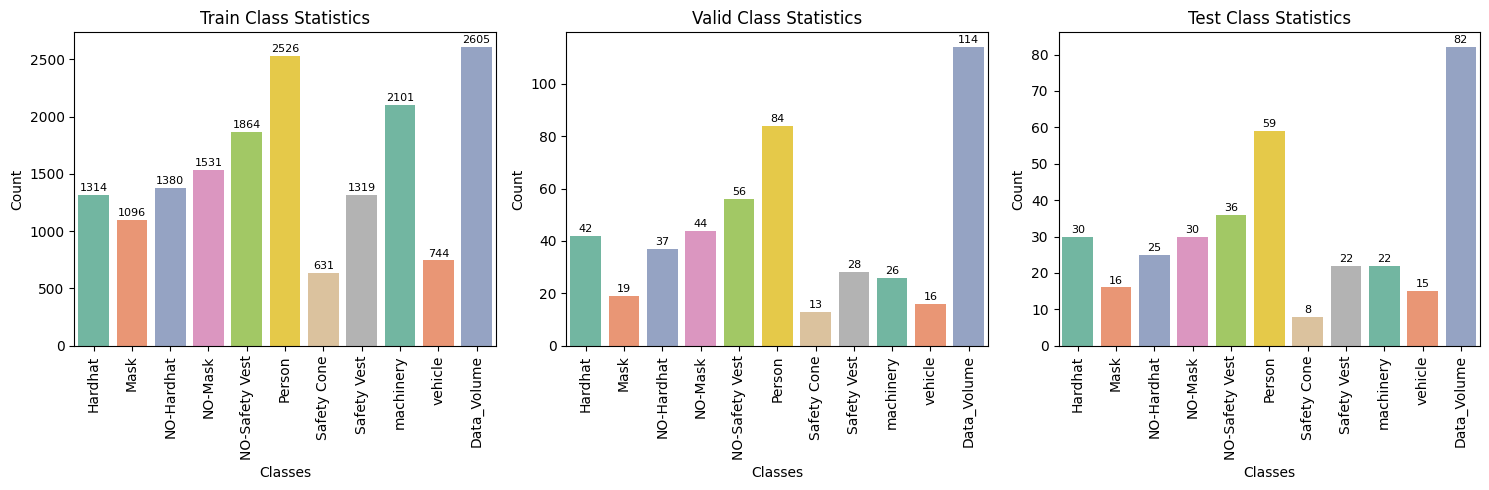

In [ ]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

## Image sizes

In [ ]:
%%time

for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(640, 640)



Image sizes in valid set:
(640, 640)



Image sizes in test set:
(640, 640)


CPU times: user 139 ms, sys: 36 ms, total: 175 ms
Wall time: 175 ms


# Base Model Inference

- Just checking the power of the pretrained model inference on the CSS dataset

In [ ]:
CFG.BASE_MODEL_WEIGHTS

'yolov8s.pt'

In [ ]:
model = YOLO('yolov8s.pt')

results = model.predict(
    source = example_image_path,

    classes = [0],
    conf = 0.40,
    device = 0, # inference with dual GPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)


image 1/1 /content/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg: 640x640 7 persons, 16.5ms
Speed: 5.8ms preprocess, 16.5ms inference, 354.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict
1 label saved to /content/runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



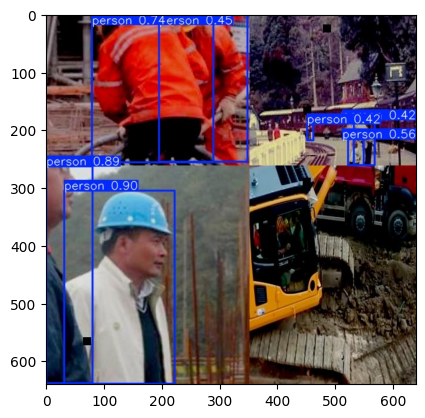

In [ ]:
### check predictions with base model
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'/content/runs/detect/predict/{example_image_inference_output}')

# Train

[Arguments for training](https://docs.ultralytics.com/modes/train/#arguments)

In [ ]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov8s.pt
Epochs:  80
Batch:  16


In [ ]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [ ]:
%%time

### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,

    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    device = 0, # 0
    verbose = False,
)

WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.025, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=(640, 640), int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_ppe_css_80_epochs, nbs=64, nms=False, opset=None, optimize=False, optimizer

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cc232bfc980>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [ ]:
from ultralytics import YOLO

# Load your trained model
# The 'best.pt' file is typically saved in the 'runs/detect/exp_name/weights/' directory.
# Make sure to replace 'path/to/best.pt' with the actual path.
model = YOLO('/content/best.pt')

# Validate the model on the 'test' split of your dataset
# The data='data.yaml' argument points to your dataset configuration file.
metrics = model.val(data='data.yaml', split='train')

# The 'metrics' object contains various performance indicators.
# For object detection, mAP50-95 is a key metric.
print(f"mAP50-95: {metrics.box.map}")
print(f"mAP50: {metrics.box.map50}")

Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1845.1±559.2 MB/s, size: 51.1 KB)
val: Scanning /content/css-data/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2605/2605 1.9Kit/s 1.4s
val: /content/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
val: /content/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed
val: New cache created: /content/css-data/train/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 163/163 4.5it/s 36.5s
                   all       2605      36893      0.948      0.833      0.891      0.719
               Hardhat       1314       3145      0.956      0.802      0.867      0.658
            

# Export

- [Export mode](https://docs.ultralytics.com/modes/export/) is used for exporting a YOLOv8 model to a format that can be used for deployment. In this mode, the model is converted to a format that can be used by other software applications or hardware devices. This mode is useful when deploying the model to production environments.

In [ ]:
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

In [ ]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.30GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs

PyTorch: starting from 'runs/detect/yolov8s_ppe_css_80_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (21.5 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 2.3s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.0 opset 19...
ONNX: export success ✅ 3.8s, saved as 'runs/detect/yolov8s_ppe_css_80_epochs/weights/best.onnx' (42.7 MB)

Export complete (5.1s)
Results saved to /content/runs/detect/yolov8s_ppe_css_80_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/y

'runs/detect/yolov8s_ppe_css_80_epochs/weights/best.onnx'

# Train results

In [ ]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['./runs/detect/yolov8s_ppe_css_80_epochs/confusion_matrix.png',
 './runs/detect/yolov8s_ppe_css_80_epochs/results.png',
 './runs/detect/yolov8s_ppe_css_80_epochs/BoxR_curve.png',
 './runs/detect/yolov8s_ppe_css_80_epochs/BoxP_curve.png',
 './runs/detect/yolov8s_ppe_css_80_epochs/BoxPR_curve.png',
 './runs/detect/yolov8s_ppe_css_80_epochs/confusion_matrix_normalized.png',
 './runs/detect/yolov8s_ppe_css_80_epochs/BoxF1_curve.png',
 './runs/detect/yolov8s_ppe_css_80_epochs/labels.jpg']

# Loss

- The loss function in YOLO consists of three main components: box loss, class loss (cls loss), and objectness loss (dfl loss).
- The total loss in YOLO is a combination of these three components

___

**Box loss:**
- The box loss measures how accurately the predicted bounding box coordinates match the ground truth bounding box.
- Is typically computed using a regression loss, such as Mean Squared Error (MSE), between the predicted bounding box coordinates (center coordinates, width, and height) and the ground truth bounding box coordinates.

___

**Class loss (cls):**
- The class loss measures how well the predicted class probabilities match the true class labels.
- The class loss is usually computed using a categorical cross-entropy loss, which penalizes the difference between the predicted class probabilities and the true class labels.

___

**Objectness loss (dfl):**
- Distribution Focal Loss
- YOLO predicts an "objectness" score for each bounding box, indicating the presence of an object within the grid cell. This score helps filter out irrelevant bounding boxes.
- The objectness loss is calculated based on the difference between the predicted objectness score and the ground truth objectness label. It penalizes the model for false positives and false negatives in predicting the presence of an object.

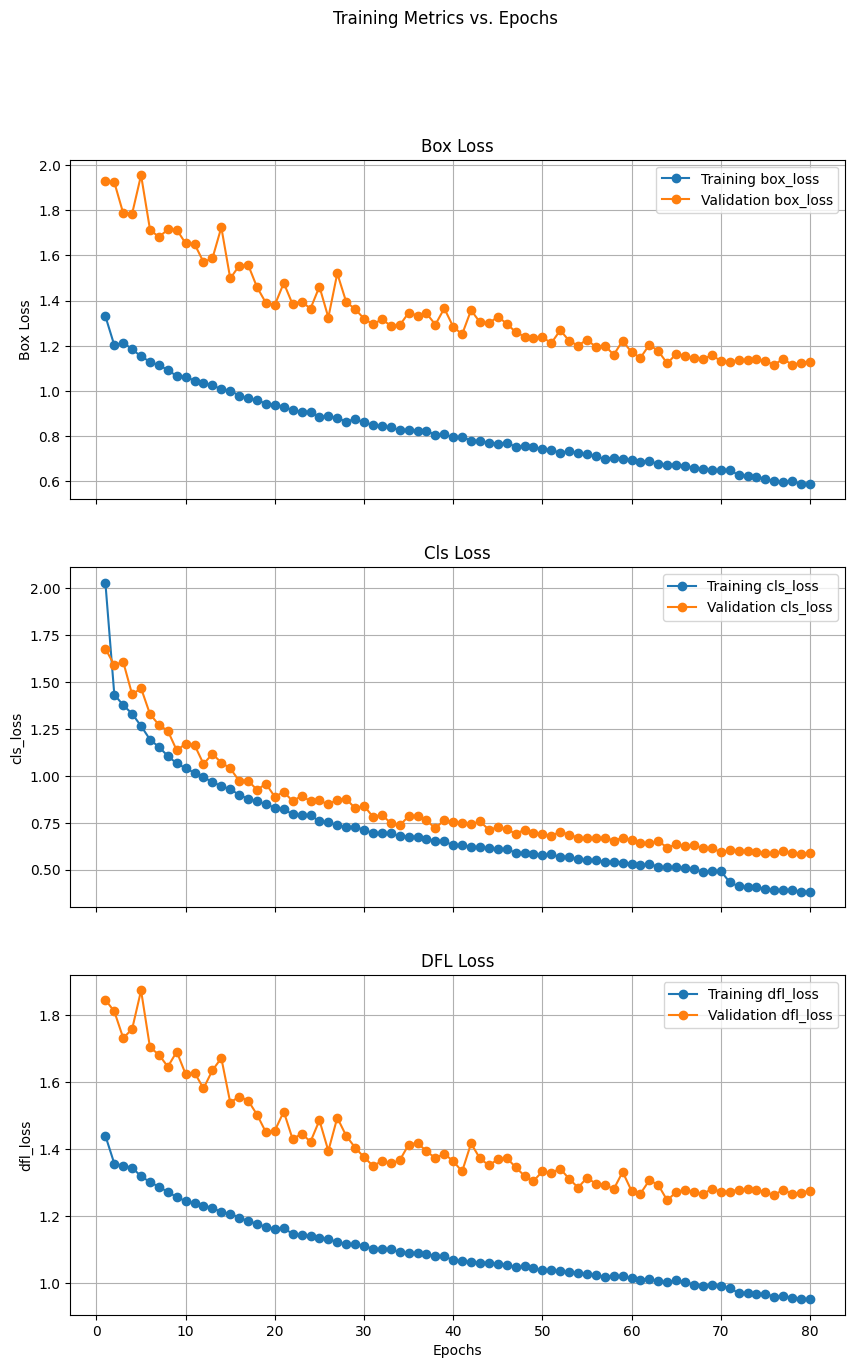

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

# Validation results

In [ ]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [ ]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

./runs/detect/yolov8s_ppe_css_80_epochs/val_batch2_pred.jpg


./runs/detect/yolov8s_ppe_css_80_epochs/val_batch1_labels.jpg


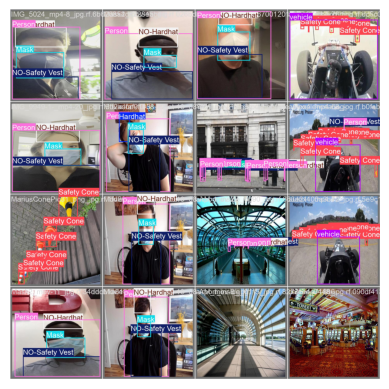

In [ ]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)


image 1/1 /content/css-data/test/images/000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg: 640x640 2 Hardhats, 2 NO-Masks, 3 Persons, 16.3ms
Speed: 1.9ms preprocess, 16.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2


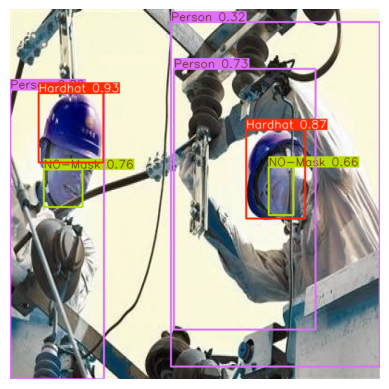

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load the trained model
model = YOLO("runs/detect/yolov8s_ppe_css_80_epochs/weights/best.pt")

# Run prediction on ONE image
results = model.predict("/content/css-data/test/images/000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg", save=True)

# Show the image with predictions
plt.imshow(results[0].plot())
plt.axis("off")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save model to Google Drive
model.save("/content/drive/MyDrive/my_model.h5")


Mounted at /content/drive


In [ ]:
model.save("my_model.h5")

# Conclusions

- So now the model is trained and we have customized Yolo to detect PPE.
- In my [next notebook](https://www.kaggle.com/hinepo/yolov8-inference-for-red-zone-application) I will use this model to make inference on a video, and combine the PPE detection with a Red Zone application.
- **<font color='orange'>Upvote if you liked it!</font>**